In [100]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
from src.utils import read_netmhcpan_results, get_filtered_df, filter_rank
from src.data_processing import get_aa_properties
from src.partition_tools import pipeline_stratified_kfold
from src.sequence_handling import AA_KEYS
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
pal = sns.color_palette('hsv', n_colors=13)
pal = [pal[6], pal[9], pal[-1]]
sns.set_palette(pal)
mpl.rcParams['figure.dpi'] = 180
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pal = sns.color_palette('hsv', n_colors=13)
sns.set_palette([pal[-4], pal[-1]])

In [4]:
datadir = '../data/immunopeptidome/'
os.listdir(datadir)

['adamopoulou_supp_data_pepts_and_source_prot.xls',
 'espinosa_pep_thymus_man_extracted.txt',
 'export_hpa_thymus.tsv',
 'GSM6261174_TTA7_filtered_feature_bc_matrix.h5',
 'hp_adamo_espino_merged.txt',
 'human_thymus_atlas',
 'NOT.tsv',
 'sciimmunol.abl5053_data_file_s1.zip',
 'wang_doi 10.1126sciimmunol.abl5053.zip']

In [6]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')

# Checking CEDAR & related parent peptide

This code gets the similarity to self (using kernel dist, kmin=1, kmax=8),

also checks the predicted ELrank to its putative HLA and check if it's an "improved binder" or not (yes if %rank(normal)/%rank(mutated) > 1.2)

## data filtering and saving for kern_dist

In [5]:
# Reading epi & raw files
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
cedar_raw = pd.ExcelFile('../data/raw_exports/neo_JUN2022_full_res.xlsx')
# Getting the "full" sheet
cedar_full = pd.read_excel(cedar_raw, 'full')
cedar_full = cedar_full[['Epitope_Description','Related Object_Description', 'Related Object_Object Type', 
                         'Related Object_Parent Protein IRI', 'MHC_Allele Name']]
cedar_full['equal'] = cedar_full.apply(lambda x: x['Epitope_Description'] == x['Related Object_Description'], axis=1)
cedar_full['not_pep'] = cedar_full.apply(lambda x: x['Related Object_Description'] != x['Related Object_Description'].upper(), axis=1)

In [6]:
# Merging & removing seqs with X
cedar_full['MHC_Allele Name'] = cedar_full['MHC_Allele Name'].str.replace('*','')
# Merges
merged=cedar.merge(cedar_full, left_on=['Peptide', 'HLA'], right_on=['Epitope_Description', 'MHC_Allele Name']).drop_duplicates()
# Removes related that don't have peptide sequence
merged.drop(merged.loc[merged.not_pep==True].index, inplace=True)
# Removes any that has X in either peptide or related sequence
x_idx = merged.query('Peptide.str.contains("X") or `Related Object_Description`.str.contains("X")', engine='python').index
merged = merged.drop(x_idx)
merged.reset_index(drop=True)
# Saving stuff for netmhcpan and kernel dist 
merged['Related Object_Description'].to_csv('../../../kern_dist/cedar_related.pep', index=False, header=False)
merged[['Peptide','Related Object_Description']].to_csv('../../../kern_dist/cedar_peps.pep', index=False, header=False, sep='\t')

In [6]:
len(merged)

3475

## loading kerndist results

,similarity,total_count,percentage_pos,agg_label,len,trueHLA_EL_rank,pred_EL_score,pred_EL_rank,BA_score,BA_rank
count,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000
mean,0.942073,1.433094,0.162586,0.189065,9.600863,2.129335,0.525279,0.839028,0.597792,0.685428
std,0.054191,1.534969,0.350130,0.391616,0.858665,3.877178,0.317816,1.519432,0.193031,1.289900
min,0.587055,1.000000,0.000000,0.000000,8.000000,0.000600,0.000700,0.000300,0.051300,0.003400
25%,0.928652,1.000000,0.000000,0.000000,9.000000,0.216900,0.230600,0.069750,0.460300,0.064450
50%,0.952979,1.000000,0.000000,0.000000,9.000000,0.803100,0.531900,0.306500,0.621700,0.250500
75%,0.972827,1.000000,0.000000,0.000000,10.000000,2.407750,0.835350,0.921500,0.747850,0.746950
max,1.000000,42.000000,1.000000,1.000000,12.000000,52.692300,0.998900,22.854600,0.973000,22.058900


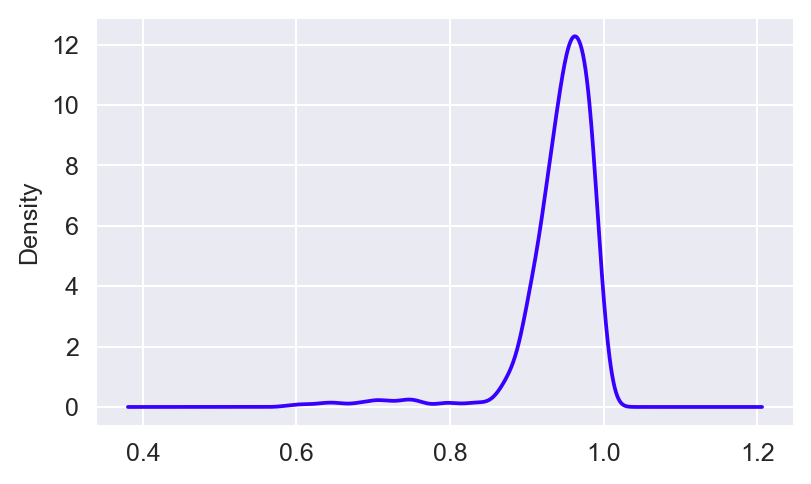

In [7]:
# re-loading results and merging
dist = pd.read_csv('../../../kern_dist/out/cedar_peps.pep_kerndist.out', header=None).rename(columns={0:'similarity'})
merged = merged.reset_index(drop=True)
merged = merged.merge(dist, left_index=True, right_index=True)
merged = merged[['Peptide','Related Object_Description', 'HLA', 'similarity', 'total_count', 'Related Object_Parent Protein IRI',
       'percentage_pos', 'agg_label', 'len', 'trueHLA_EL_rank', 'pred_HLA',
       'core', 'icore', 'pred_EL_score', 'pred_EL_rank', 'BA_score', 'BA_rank']]
merged.similarity.plot(kind='kde',figsize=(5,3))
merged.describe()

In [8]:
# Remove entries with related object with length < 8
merged['rel_len'] = merged['Related Object_Description'].apply(len)
drop_idx = merged.query('rel_len<8').index
merged = merged.drop(drop_idx)
merged['Related Object_Description'].to_csv('../../../kern_dist/cedar_related.pep', index=False, header=False)
len(merged)

3459

## Getting NetMHCpan ranks to see if improved/not binder

In [9]:
# Ranks stuff
from src.utils import get_trueHLA_EL_rank
related_xls = read_netmhcpan_results('../data/cedar_xls/cedar_related.pep.xls')
related_df = merged.drop(columns=['Peptide']).rename(columns={'Related Object_Description':'Peptide'})
related_scored = get_trueHLA_EL_rank(related_df,
                                     related_xls).rename(columns={'Peptide':'Related Object_Description',
                                                          'trueHLA_EL_rank': 'Related_EL_rank'})[['Related Object_Description', 'Related_EL_rank']]
# Assert that all values are identical (i.e. in the same order otherwise breaks) so I can reset index and merge in index instead
assert all(merged['Related Object_Description'].values==related_scored['Related Object_Description'].values)==True, 'break'
merged.reset_index(drop=True,inplace=True)
related_scored.reset_index(drop=True,inplace=True)

merged = merged.merge(related_scored[['Related_EL_rank']], left_index=True, right_index=True)
merged['binder'] = merged.apply(lambda x: 'IB' if x['Related_EL_rank']/x['trueHLA_EL_rank'] > 1.2 else 'CB', axis=1)
first_cols = ['Peptide', 'Related Object_Description', 'HLA', 'similarity', 'trueHLA_EL_rank', 
              'Related_EL_rank', 'binder', 'agg_label', 'len', 'rel_len', 'Related Object_Parent Protein IRI']
rest_cols = [x for x in merged.columns if x not in first_cols]
first_cols.extend(rest_cols)
merged = merged[first_cols]

In [10]:
merged.groupby(['binder','agg_label']).count()

Peptide  Related Object_Description   HLA  similarity  \
binder agg_label                                                          
CB     0             1347                        1347  1347        1347   
       1              271                         271   271         271   
IB     0             1463                        1463  1463        1463   
       1              378                         378   378         378   

                  trueHLA_EL_rank  Related_EL_rank   len  rel_len  \
binder agg_label                                                    
CB     0                     1347             1347  1347     1347   
       1                      271              271   271      271   
IB     0                     1463             1463  1463     1463   
       1                      378              378   378      378   

                  Related Object_Parent Protein IRI  total_count  \
binder agg_label                                                   
CB     0                                       1274         1347   
       1                                        264          271   
IB     0                                       1390         1463   
       1                                        369          378   

                  percentage_pos  pred_HLA  core  icore  pred_EL_score  \
binder agg_label                                                         
CB     0                    1347      1347  1347   1347           1347   
       1                     271       271   271    271            271   
IB     0                    1463      1463  1463   1463           1463   
       1                     378       378   378    378            378   

                  pred_EL_rank  BA_score  BA_rank  
binder agg_label                                   
CB     0                  1347      1347     1347  
       1                   271       271      271  
IB     0                  1463      1463     1463  
       1                   378       378      378

## checking Similarity distribution wrt binders/ranking with some stat tests

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu, levene, bartlett

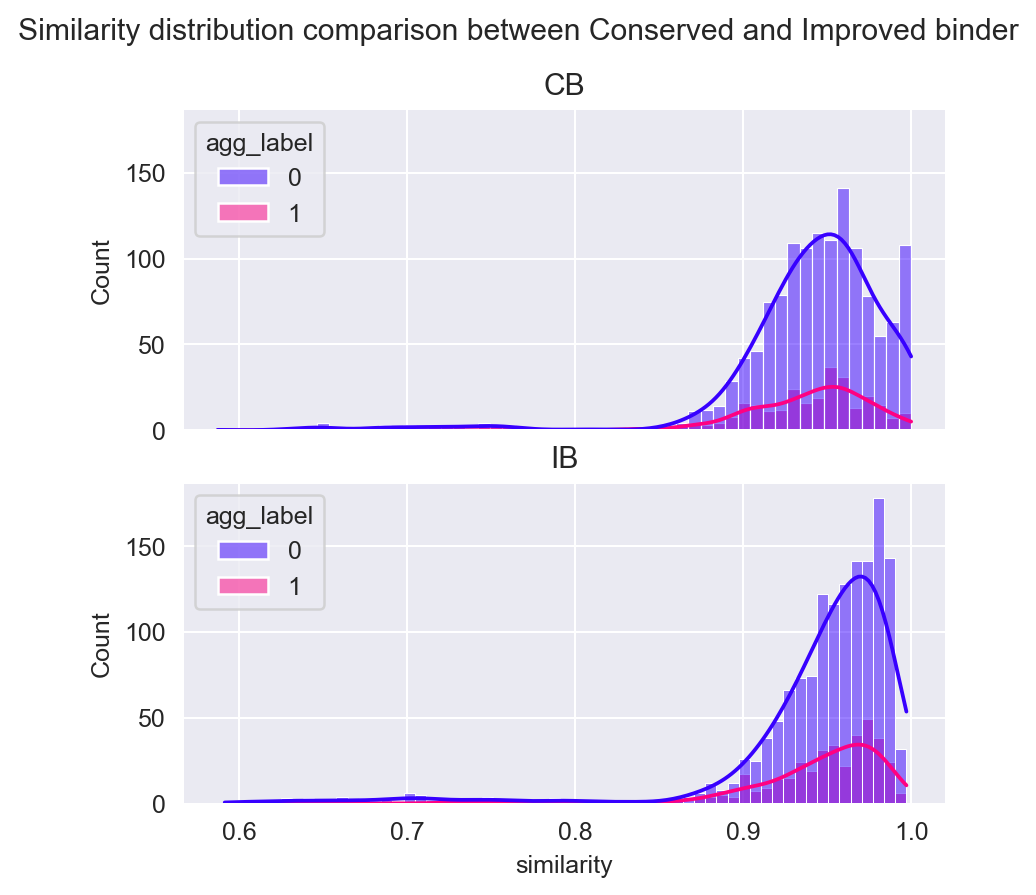

In [11]:
pal = sns.color_palette('hsv', 13)
sns.set_palette([pal[-4], pal[-1]])
f,a = plt.subplots(2,1,figsize=(5,5), sharex=True, sharey=True)
sns.histplot(data=merged.query('binder=="CB"'), x = 'similarity', hue='agg_label', ax=a[0], kde=True, alpha=0.5)
sns.histplot(data=merged.query('binder=="IB"'), x = 'similarity', hue='agg_label', ax=a[1], kde=True, alpha=0.5)
a[0].set_title('CB')
a[1].set_title('IB')
f.suptitle('Similarity distribution comparison between Conserved and Improved binder')
plt.tight_layout(w_pad=0.1, h_pad=0.055, pad=0.9)

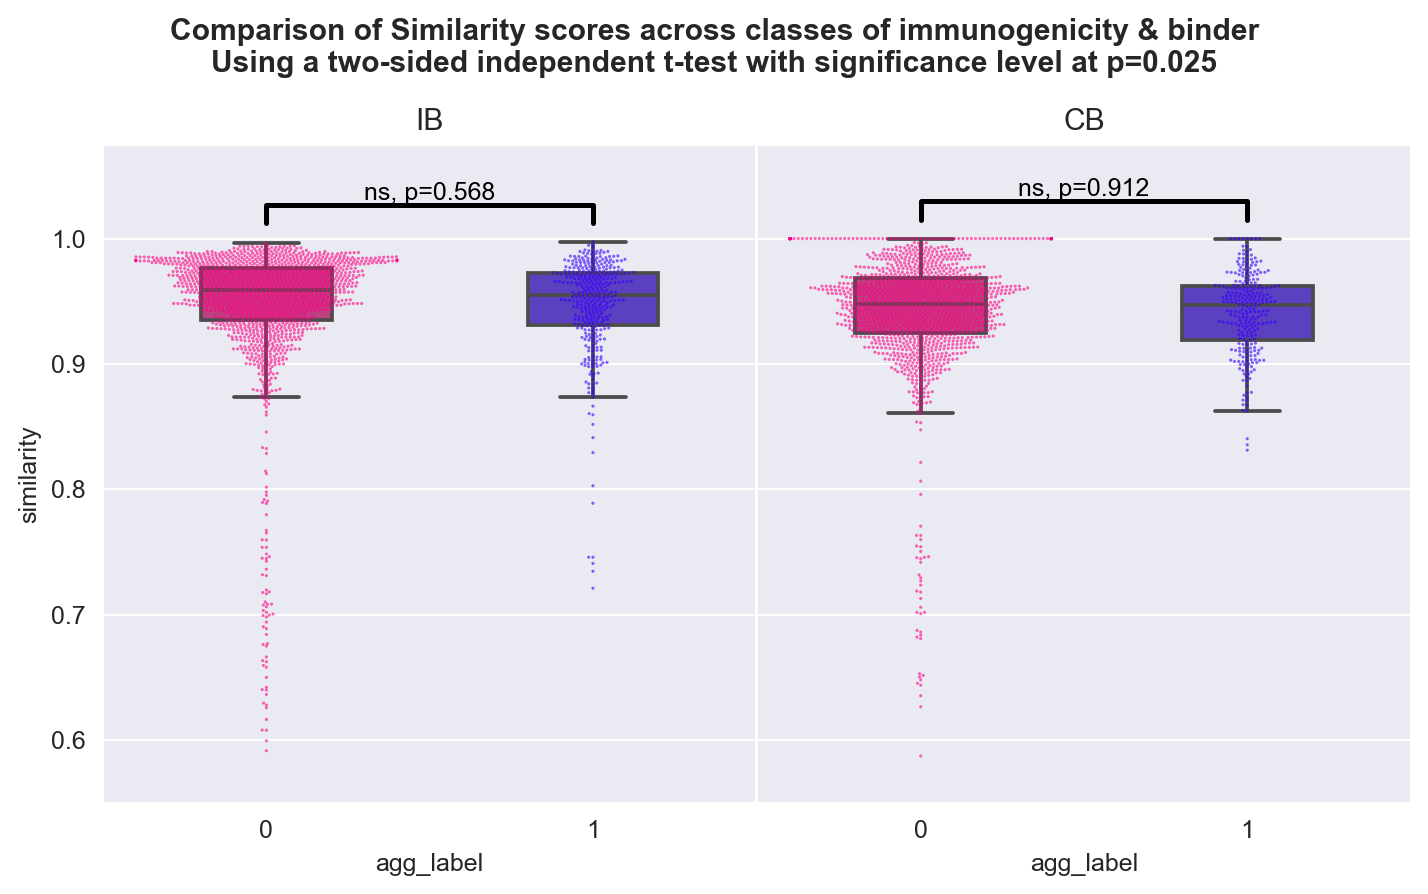

In [18]:
pal = sns.color_palette('hsv', n_colors=13)
sns.set_palette([pal[-1], pal[-4]])
f,a = plt.subplots(1,2, figsize=(8,5),sharey=True)
for i,binder in enumerate(['IB', 'CB']):
    df=merged.query('binder==@binder')
    sns.boxplot(data=df, x='agg_label', y = 'similarity', 
                ax = a[i], saturation=0.5, width=0.4, showfliers=False)
    sns.swarmplot(data=df, x='agg_label', y ='similarity',
                  ax = a[i], alpha = 0.6, size=1.25)
    pos=df.query('agg_label==1')['similarity'].values
    neg=df.query('agg_label==0')['similarity'].values
    # greater = mean of first is greater than mean of second.
    # first = neg, second = pos, then neg should have greater sim than pos
    pval = ttest_ind(neg, pos, alternative='two-sided')[1]
    label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
    # Drawing Pval */ns rectangles
    x1, x2 = 0, 1
    y, h, col = df['similarity'].max() + 0.015, 0.015, 'k'
    a[i].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
    a[i].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
    a[i].set_title(binder)
    if i>0:
        a[i].set_ylabel(None)
    a[i].set_ylim([0.55, 1.075])
f.suptitle('Comparison of Similarity scores across classes of immunogenicity & binder\n'\
           'Using a two-sided independent t-test with significance level at p=0.025',
          fontweight='semibold')
f.tight_layout(w_pad=0.05, h_pad=0.005, pad = .95)

In [13]:
for i,binder in enumerate(['IB', 'CB']):
    print(f'######### {binder} #########\n')
    df=merged.query('binder==@binder')
    pos=df.query('agg_label==1')['similarity'].values
    neg=df.query('agg_label==0')['similarity'].values
    for alt in ['two-sided','less']:
        print(f'Alternative: {alt}')
        pv_mw = mannwhitneyu(pos, neg, alternative=alt)[1]
        pv_t = ttest_ind(pos, neg, alternative=alt)[1]
        print(f'MWU:\t{pv_mw}')
        print(f't-test:\t{pv_t}')
        print('\n')
    pv_levene = levene(pos,neg)[1]
    print(f'Levene:\t{pv_levene}\n')

######### IB #########

Alternative: two-sided
MWU:	0.05060604195942195
t-test:	0.5681883351034489


Alternative: less
MWU:	0.025303020979710975
t-test:	0.7159058324482757


Levene:	0.11754882882475265

######### CB #########

Alternative: two-sided
MWU:	0.08885825966321646
t-test:	0.9120451345702933


Alternative: less
MWU:	0.04442912983160823
t-test:	0.5439774327148534


Levene:	0.04112581425356449



## CEDAR Hobohm & partitioning scratchpad

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedGroupKFold

### Reading the hobohm grouping and getting Unique vs Not Unique sets

In [15]:
with open('../out/cedar_peps_hobohm_0.925.pep', 'r') as f:
    lines = [l.strip('\n') for l in f.readlines()]

In [ ]:
res = {}
for fn in ['../out/cedar_peps_hobohm_0.925.pep', '../out/cedar_peps_hobohm_0.9.pep']:
    key = fn.split('hobohm_0.')[1].split('.pep')[0]
    df = pd.read_csv(fn, header=None, comment = '#')
    df.columns = ['Peptide']
    df = df.merge(cedar[['Peptide', 'agg_label', 'HLA', 'trueHLA_EL_rank']], left_on='Peptide', right_on='Peptide')
    with open(fn, 'r') as f:
        lines = f.readlines()
    values = []
    for l in lines:
        if 'Not unique' not in l:continue
        l = l.replace('\n','')
        l = [x.split(' ') for x in l.split('# Not unique. ')[1].split(' is similar to ')]
        idx = l[0][0]
        discarded = l[0][1]
        similar = l[1][0]
        similarity_score = l[1][1]
        values.append([idx, similar, discarded, similarity_score])
    not_unique = pd.DataFrame(values, columns = ['drop_idx', 'similar', 'discarded', 'similarity_score'])
    not_unique['self'] = not_unique['similar']==not_unique['discarded']
    res[key] = {}
    res[key]['not_unique'] = not_unique.query('self==False')
    res[key]['unique']=df

### Choosing .9 as threshold because it gives less work

In [ ]:
unique = res['9']['unique']
not_unique = res['9']['not_unique']

### Stratify Kfold on unique set using Duplicated Counts as stratifying groups since we will have to manually re-assign those non-unique to groups

In [ ]:
# Stratify KFold on the unique set, based on duplicated counts as stratifying group.
# Then repopulate the folds with 
not_unique['drop_idx'] = not_unique['drop_idx'].astype(int)
# Get the strat KF object
stratkf = StratifiedKFold(5, shuffle=True, random_state=13) 
# Merge the not unique (to get agg_label, i.e. "y" for stratkf to split and get the duplicated counts 
not_unique = not_unique.merge(cedar.reset_index()[['index','agg_label', 'HLA','trueHLA_EL_rank']], left_on='drop_idx', right_on='index')
dup_counts = not_unique.groupby('similar').agg({'self':'count'}).sort_values('self',ascending=False).reset_index()
dup_counts = dup_counts.merge(unique[['Peptide', 'agg_label']], left_on='similar', right_on='Peptide').drop_duplicates(['similar', 'agg_label'])
# Merge and assign the duplicated counts, to be used as stratify groups
unique['counts'] = 0 
tmp = unique.reset_index().merge(dup_counts[['Peptide', 'self']], left_on='Peptide', right_on='Peptide')
unique.iloc[tmp['index'].values, unique.columns.get_loc('counts')] = tmp['self']

# Ready to stratify and set the folds
unique['fold'] = np.nan
for i, (train_idx, test_idx) in enumerate(stratkf.split(unique['Peptide'].values, unique['agg_label'], groups = unique['counts'])):
    unique.iloc[test_idx, unique.columns.get_loc('fold')] = i
unique.fold=unique.fold.astype(int)


### Manually re-assigning duplicated sequences w/ diff HLAs to the same folds

In [ ]:
k = 10
d = {x:0 for x in range(k)}

In [ ]:
# set assignment counter
assignment_counts={0:0,
                   1:0,
                   2:0,
                   3:0,
                   4:0}
# Go through all the duplicated peps
for pep in unique.loc[unique.duplicated('Peptide',keep=False)].Peptide.unique():
    tmp = unique.loc[unique['Peptide']==pep]
    # if already all the same fold then it's fine, continue
    if len(tmp.fold.unique())==1:continue
    # otherwise: assign to a fold that has the least assignments (starts at 0)
    counts = [assignment_counts[k] for k in tmp.fold.values]
    new_assignment = tmp.fold.values[counts.index(min(counts))]
    unique.loc[unique['Peptide']==pep, 'fold'] = new_assignment
    assignment_counts[new_assignment]+=1

### Manually re-assigning similar peps into the same folds as their related pep

In [ ]:
display(unique.head(3)), display(not_unique.head(3))

In [ ]:
# Re-assigning
not_unique['fold'] = not_unique.apply(lambda x: unique.query('Peptide==@x.similar')['fold'].unique()[0], axis=1)
not_unique = not_unique[['discarded', 'agg_label', 'HLA','trueHLA_EL_rank', 'fold']].rename(columns={'discarded':'Peptide'})
# Merging back
dataset = pd.concat([unique, not_unique], ignore_index=True).sort_values('Peptide',ascending=True).reset_index(drop=True).drop(columns=['counts'])

In [ ]:
merge_cols = ['Peptide', 'HLA']
merge_cols.extend(cedar.columns.difference(dataset.columns))
dataset = dataset.merge(cedar[merge_cols], left_on=['Peptide','HLA'],right_on=['Peptide','HLA'])
dataset.to_csv('../data/cedar_neoepitopes_partition_5fold.csv', index=False)

# CEDAR/HOBOHM Partitioning
Stratify Data partition using made function (fct made from previous cells)

In [19]:
from src.partition_tools import pipeline_stratified_kfold

In [23]:
# cedar
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
cedar['dataset']='cedar'
# Human proteome
hp=pd.read_csv('../output_xls/subsampled/humanprot_sub_N75_seed13_cons_True_2_scored.txt').rename(columns={'EL_Rank':'trueHLA_EL_rank',
                                                                                                           'BA_Rank':'BA_rank'})

hp[['percentage_pos', 'agg_label', 'label', 'total_count','dataset']] = 0, 0, 'Negative', 2, 'hp'
hp['len'] = hp.Peptide.apply(len)
hp['sample_weight'] = 5+ (1/(10000*hp['trueHLA_EL_rank']))
mixed_subsampled_hp = pd.concat([cedar,hp.sample(frac=0.75, weights='sample_weight', random_state=13)])

mixed_subsampled_hp['Peptide'].to_csv('../../../kern_dist/cedar_mixed_hp_sub75.pep', header=False, index=False)
mixed_subsampled_hp.to_csv('../data/cedar_mixed_hp_sub75.csv', index=False)

In [ ]:
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
len(dataset_10fold)

## Prep Viral data

In [3]:
viral = pd.read_csv('../data/heli_viral', sep ='\s')
print(viral.columns)
viral = viral.rename(columns = {'peptide_length':'len'})
# [['id', 'Icore', 'allele', 'Core', 'Rnk_EL', 'target', 'target_bin_2', 'target_qual_corrected', 'len', 'allele_mod']]
# Recover the peptide sequence
viral['Peptide']= viral.apply(lambda x: x['prot_sequence'][x['peptide_start']:x['peptide_stop']+1], axis=1)
# Quick checks that it makes sense
viral[['Peptide', 'Icore', 'Core']]

Index(['id', 'Icore', 'allele', 'prot_sequence', 'Core', 'Of', 'Gp', 'Gl',
       'Ip', 'Il', 'Rnk_EL', 'uniprot_id', 'number_papers_positive',
       'number_papers_negative', 'subj_tested', 'subj_responded', 'target',
       'target_bin_2', 'target_qual_corrected', 'peptide_length',
       'peptide_start', 'peptide_stop', 'non_aa_pep', 'non_aa_prot',
       'allele_mod', 'training'],
      dtype='object')


,Peptide,Icore,Core
0,TVTSTPVQGR,TVTSTPVQGR,TVTSTPVQR
1,TVYPPSSTAK,TVYPPSSTAK,TVYPPSSTK
2,AEWPTFNVGW,AEWPTFNVGW,AEWPTNVGW
3,ILDSFDPLV,ILDSFDPLV,ILDSFDPLV
4,RLIVFPDLGV,RLIVFPDLGV,RLIVFPLGV
...,...,...,...
16798,LLHERLDEF,LLHERLDEF,LLHERLDEF
16799,LFITSTHVI,LFITSTHVI,LFITSTHVI
16800,FTISDSATF,FTISDSATF,FTISDSATF
16801,YLQQRTFLL,YLQQRTFLL,YLQQRTFLL


In [5]:
cedar_hlas = cedar.HLA.unique()
common_hlas = [x for x in viral.allele_mod.unique() if x in cedar_hlas]
viral_not = [x for x in viral.allele_mod.unique() if x not in cedar_hlas]
# Sampling from viral:
samples = []
for target in [0, 1]:
    k = 10 if target == 1 else 15
    for allele in common_hlas:
        tmp = viral.query('allele_mod == @allele and target == @target')
        n = min(len(tmp), k)
        ss= tmp.sample(n, random_state=13)
        samples.append(ss)
viral_samples = pd.concat(samples).reset_index(drop=True)
viral_samples['dataset'] = 'viral'
viral_samples.rename(columns = {'Rnk_EL':'trueHLA_EL_rank',
                                'target':'agg_label',
                                'allele_mod':'HLA'}, inplace=True)
# Concatenate and saving for hobohm
cedar_viral = pd.concat([cedar,viral_samples]).reset_index(drop=True)
cedar_viral['Peptide'].to_csv('../../../kern_dist/data/cedar_viral.pep', index=False, header=False)

NameError: name 'cedar' is not defined

In [8]:
from src.partition_tools import pipeline_stratified_kfold
cedar_viral_fold = pipeline_stratified_kfold('../../../kern_dist/out/cedar_viral.pep_0.9.pep', cedar_viral, k=10)
cedar_viral_fold.groupby(['fold', 'agg_label']).count()

Peptide  HLA  trueHLA_EL_rank  BA_rank  BA_score  Core  Gl  \
fold agg_label                                                               
0    0              320  320              320      282       282    38  38   
     1              110  110              110       78        78    32  32   
1    0              313  313              313      270       270    43  43   
     1               94   94               94       56        56    38  38   
2    0              317  317              317      281       281    36  36   
     1              102  102              102       62        62    40  40   
3    0              328  328              328      288       288    40  40   
     1              107  107              107       69        69    38  38   
4    0              333  333              333      293       293    40  40   
     1              104  104              104       57        57    47  47   
5    0              339  339              339      298       298    41  41   
     1              109  109              109       67        67    42  42   
6    0              326  326              326      289       289    37  37   
     1               99   99               99       55        55    44  44   
7    0              314  314              314      279       279    35  35   
     1              102  102              102       68        68    34  34   
8    0              303  303              303      265       265    38  38   
     1              105  105              105       69        69    36  36   
9    0              315  315              315      282       282    33  33   
     1              100  100              100       72        72    28  28   

                Gp  Icore  Il  Ip  Of  PMIDs  allele  core  dataset  icore  \
fold agg_label                                                               
0    0          38     38  38  38  38    282      38   282       38    282   
     1          32     32  32  32  32     78      32    78       32     78   
1    0          43     43  43  43  43    270      43   270       43    270   
     1          38     38  38  38  38     56      38    56       38     56   
2    0          36     36  36  36  36    281      36   281       36    281   
     1          40     40  40  40  40     62      40    62       40     62   
3    0          40     40  40  40  40    288      40   288       40    288   
     1          38     38  38  38  38     69      38    69       38     69   
4    0          40     40  40  40  40    293      40   293       40    293   
     1          47     47  47  47  47     57      47    57       47     57   
5    0          41     41  41  41  41    298      41   298       41    298   
     1          42     42  42  42  42     67      42    67       42     67   
6    0          37     37  37  37  37    289      37   289       37    289   
     1          44     44  44  44  44     55      44    55       44     55   
7    0          35     35  35  35  35    279      35   279       35    279   
     1          34     34  34  34  34     68      34    68       34     68   
8    0          38     38  38  38  38    265      38   265       38    265   
     1          36     36  36  36  36     69      36    69       36     69   
9    0          33     33  33  33  33    282      33   282       33    282   
     1          28     28  28  28  28     72      28    72       28     72   

                id  label  len  non_aa_pep  non_aa_prot  \
fold agg_label                                            
0    0          38    282  320          38           38   
     1          32     78  110          32           32   
1    0          43    270  313          43           43   
     1          38     56   94          38           38   
2    0          36    281  317          36           36   
     1          40     62  102          40           40   
3    0          40    288  328          40           40   
     1          38     69  107          38         

In [258]:
cedar_viral_fold.to_csv('../data/script_traindata/cedar_viral_10fold.csv', index=False)

## Remake PRIME as training set

In [115]:
prime=pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime, _ = get_aa_properties(prime)
prime['len'] = prime['Peptide'].apply(len)

prime.to_csv('../data/partitioned_traindata_redo/prime_5fold.csv')

## REDO CEDAR-VIRAL (SAMPLE 2827 NEG, 653 POS)

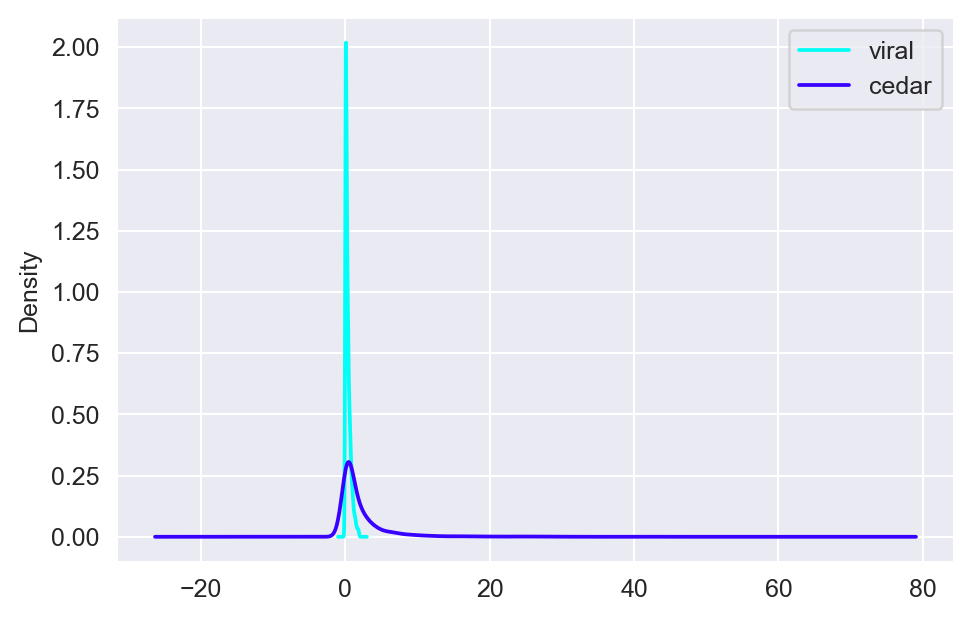

In [31]:
import math
viral['sampling_weight'] = viral['Rnk_EL'].apply(lambda x : 1/(1+x**3))
f,a = plt.subplots(1,1, figsize=(6,4))
viral.sample(3800, weights='sampling_weight').Rnk_EL.plot(kind='kde', ax = a, label='viral')
cedar.trueHLA_EL_rank.plot(kind='kde', ax = a, label='cedar')
a.legend()

In [85]:
cedar_hlas = cedar.HLA.unique()
common_hlas = [x for x in viral.allele_mod.unique() if x in cedar_hlas]
# Keep only virals that are in common HLAs.
viral_ = viral.query('allele_mod in @common_hlas')
# Then, should use HLA count as a weight
counts = viral_.groupby(['allele_mod', 'target']).agg(count=('Peptide','count'))[['count']]
counts['prop']=counts['count'].apply(lambda x: 10*x/len(viral_))
mapping = counts['prop'].to_dict()
viral_['sample_weight'] = viral_.apply(lambda x: mapping[(x['allele_mod'], x['target'])], axis=1)
samples_neg = viral_.query('target==0').sample(n=2827, weights = 'sample_weight')
samples_pos = viral_.query('target==1').sample(n=653, weights = 'sample_weight')
samples = pd.concat([samples_neg, samples_pos]).reset_index(drop=True)
samples['dataset'] = 'viral'
samples.rename(columns = {'Rnk_EL':'trueHLA_EL_rank',
                          'target':'agg_label',
                          'allele_mod':'HLA'}, inplace=True)
cedar['dataset'] = 'cedar'
new_cedar_viral = pd.concat([cedar, samples[['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label']]]).sort_values('Peptide')
new_aaprop, _ = get_aa_properties(new_cedar_viral)


In [101]:
# Use similarity to make folds, 5 fold.
new_aaprop['Peptide'].to_csv('../../../kern_dist/data/new_cedar_viral.pep', index=False, header=False)
new_cedar_viral_fold = pipeline_stratified_kfold('../../../kern_dist/out/new_cedar_viral.pep_0.85.pep', 
                                                 new_aaprop)

In [114]:
new_cedar_viral_fold['len'] = new_cedar_viral_fold['Peptide'].apply(len)
new_cedar_viral_fold.to_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')

## REDO with viral only

In [93]:
samples_neg = viral_.query('target==0').sample(n=2827*2, weights = 'sample_weight')
samples_pos = viral_.query('target==1').sample(n=653*2, weights = 'sample_weight')
new_viral_ = pd.concat([samples_neg, samples_pos]).reset_index(drop=True).sort_values('Peptide')                          
new_viral_['dataset'] = 'viral'
new_viral_.rename(columns = {'Rnk_EL':'trueHLA_EL_rank',
                          'target':'agg_label',
                          'allele_mod':'HLA'}, inplace=True)
new_viral_, _ = get_aa_properties(new_viral_[['Peptide', 'agg_label', 'HLA', 'trueHLA_EL_rank']])
new_viral_['Peptide'].to_csv('../../../kern_dist/data/new_viral_only.pep', index=False, header=False)

In [102]:
new_viral_fold = pipeline_stratified_kfold('../../../kern_dist/out/new_viral_only.pep_0.85.pep', 
                                           new_viral_)

In [113]:
new_viral_fold['len'] = new_viral_fold['Peptide'].apply(len)
new_viral_fold.to_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')

### redo cedar

In [108]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar, _ = get_aa_properties(cedar)
cedar.to_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')

In [109]:
from src.utils import flatten_product
from itertools import product

encode_blosum_zip = zip(['onehot', 'blosum', 'blosum'], [None, 1, 1])
# Weighting zip (ic dict, ic name, mask bool)
ics_mask_zip = zip([1, 1, 1, 1], ['Shannon', 'KL', 'None', 'Mask'],
                   [False, False, False, True])
# True/False zips for add_rank, add_aaprop, remove_pep
features_zip = zip([True, True, False, False],
                   [True, False, True, False],
                   [False, False, False, False])

# Lone conditions (to be producted so not zipped)
train_datasets = [1, 2, 3,4 ]
standardize_ = [True]

conditions = product(train_datasets,
                         product(encode_blosum_zip,
                                 product(ics_mask_zip,
                                         product(features_zip,
                                                 product(standardize_)))))

conditions = list(list(flatten_product(x)) for x in conditions)

In [112]:
len(conditions)*2

384